# Data Generation using Simulation for Machine Learning
## Simulation using SimPy

This notebook demonstrates how simulation-based data generation can be used to train and evaluate machine learning models.

## 1. Installing Required Libraries

We use SimPy for discrete-event simulation, along with common data science libraries.

In [29]:
!pip install simpy

## 2. Importing Required Libraries

In [30]:
import simpy
import random
import numpy as np

## 3. Simulation Model

We model a queueing system where customers arrive randomly and are served by a limited number of servers.
The key output of the simulation is the average waiting time.

In [31]:
def customer(env, name, server, service_time, wait_times):
    arrival_time = env.now

    with server.request() as request:
        yield request
        wait_time = env.now - arrival_time
        wait_times.append(wait_time)

        yield env.timeout(service_time)

In [32]:
def run_simulation(arrival_rate, service_time, num_servers, sim_time=50):
    env = simpy.Environment()
    server = simpy.Resource(env, capacity=num_servers)

    wait_times = []

    def arrival_process(env):
        i = 0
        while True:
            yield env.timeout(random.expovariate(arrival_rate))
            i += 1
            env.process(customer(env, f"Customer {i}", server, service_time, wait_times))

    env.process(arrival_process(env))
    env.run(until=sim_time)

    if len(wait_times) == 0:
        return 0
    return np.mean(wait_times)

## 4. Testing the Simulation Model

Before generating large-scale data, we test the simulation with fixed parameters.

In [33]:
avg_wait = run_simulation(
    arrival_rate=2.0,
    service_time=2.0,
    num_servers=1
)

print("Average waiting time:", avg_wait)

Average waiting time: 19.077629032382017


## 5. Dataset Generation using Simulation

We generate 1000 simulations by randomly sampling parameters within predefined bounds.

In [34]:
import pandas as pd
import random

data = []

NUM_SIMULATIONS = 1000

for _ in range(NUM_SIMULATIONS):
    arrival_rate = random.uniform(0.5, 5.0)
    service_time = random.uniform(0.5, 4.0)
    num_servers = random.randint(1, 3)

    avg_wait_time = run_simulation(
        arrival_rate,
        service_time,
        num_servers
    )

    data.append([
        arrival_rate,
        service_time,
        num_servers,
        avg_wait_time
    ])

df = pd.DataFrame(
    data,
    columns=[
        "arrival_rate",
        "service_time",
        "num_servers",
        "avg_wait_time"
    ]
)

df.head()

,arrival_rate,service_time,num_servers,avg_wait_time
0,4.858880,1.339297,2,17.843097
1,1.180779,2.833185,3,7.360425
2,3.046600,2.924842,1,20.952270
3,3.645628,1.171497,1,18.805526
4,2.849712,1.236585,1,19.919218


In [35]:
df.to_csv("simpy_dataset.csv", index=False)
print("Dataset saved successfully!")

Dataset saved successfully!


In [36]:
import pandas as pd

df = pd.read_csv("simpy_dataset.csv")
df.head()

,arrival_rate,service_time,num_servers,avg_wait_time
0,4.858880,1.339297,2,17.843097
1,1.180779,2.833185,3,7.360425
2,3.046600,2.924842,1,20.952270
3,3.645628,1.171497,1,18.805526
4,2.849712,1.236585,1,19.919218


## 6. Exploratory Data Analysis

Statistical summary of generated dataset.

In [37]:
df.describe()

,arrival_rate,service_time,num_servers,avg_wait_time
count,1000.000000,1000.000000,1000.00000,1000.000000
mean,2.782662,2.207811,1.92700,13.496054
std,1.294803,1.011263,0.82362,7.252765
min,0.500077,0.500007,1.00000,0.000000
25%,1.651486,1.303999,1.00000,8.277076
50%,2.803794,2.187349,2.00000,15.505718
75%,3.861523,3.092966,3.00000,19.612808
max,4.998838,3.991848,3.00000,23.473238


 Distribution of Input Parameters

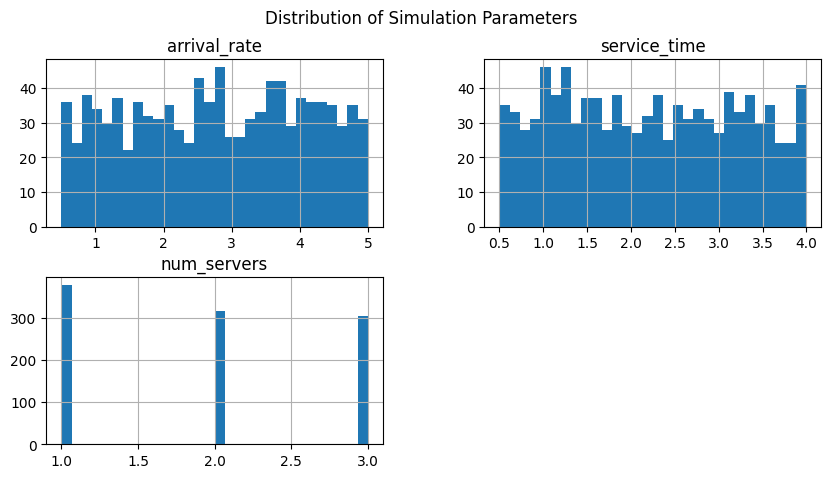

In [38]:
import matplotlib.pyplot as plt

df[["arrival_rate", "service_time", "num_servers"]].hist(
    figsize=(10, 5),
    bins=30
)

plt.suptitle("Distribution of Simulation Parameters")
plt.savefig("parameter_distributions.png", bbox_inches="tight")
plt.show()

## 7. Feature and Target Selection

The input parameters are used as features, and the average waiting time is used as the target variable.

In [39]:
X = df[["arrival_rate", "service_time", "num_servers"]]
y = df["avg_wait_time"]

## 8. Train-Test Split

The dataset is split into training and testing sets to evaluate model performance.

In [40]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

## 9. Machine Learning Models

Multiple regression models are trained to predict average waiting time from simulation parameters.

In [41]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

In [42]:
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "SVR": SVR(),
    "KNN": KNeighborsRegressor()
}

## 10. Model Training and Evaluation

Models are evaluated using MAE, RMSE, and R² score.

In [43]:
results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    results.append([name, mae, rmse, r2])

results_df = pd.DataFrame(
    results,
    columns=["Model", "MAE", "RMSE", "R2 Score"]
)

results_df.sort_values(by="RMSE")

,Model,MAE,RMSE,R2 Score
4,SVR,1.216545,1.718788,0.941872
3,Gradient Boosting,1.333666,1.781606,0.937545
2,Random Forest,1.316163,1.863083,0.931702
5,KNN,1.342275,1.955533,0.924756
1,Decision Tree,1.633260,2.298737,0.896027
0,Linear Regression,2.152302,2.752034,0.850979


## 11. Model Comparison

Visualization of model performance using RMSE.

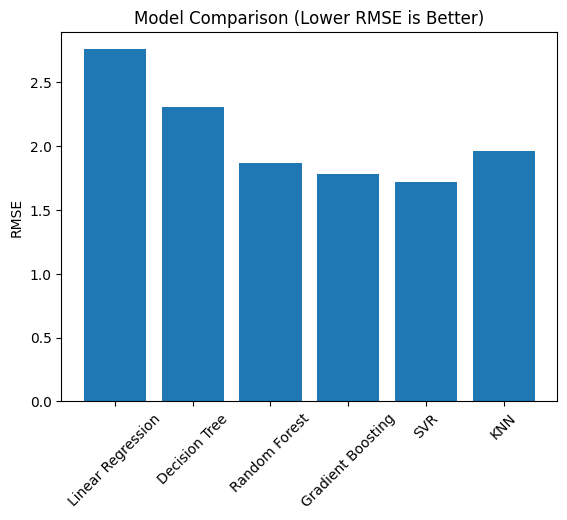

In [44]:
import matplotlib.pyplot as plt

plt.figure()
plt.bar(results_df["Model"], results_df["RMSE"])
plt.xticks(rotation=45)
plt.ylabel("RMSE")
plt.title("Model Comparison (Lower RMSE is Better)")
plt.savefig("model_comparison.png", bbox_inches="tight")
plt.show()

Comparison of Machine Learning Models on Different Metrics

This plot compares multiple regression models using MAE, RMSE, and R² score.

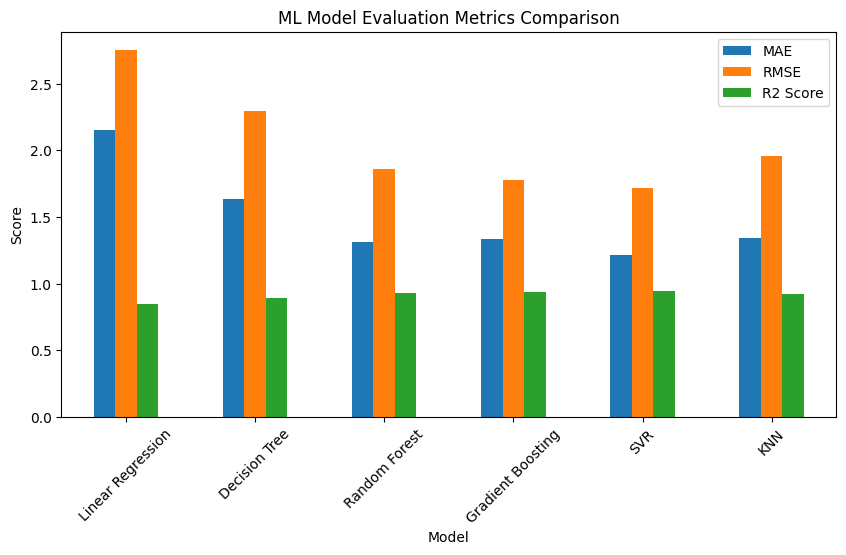

In [45]:
metrics = ["MAE", "RMSE", "R2 Score"]

results_df.set_index("Model")[metrics].plot(
    kind="bar",
    figsize=(10, 5)
)

plt.title("ML Model Evaluation Metrics Comparison")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.savefig("model_metrics_comparison.png", bbox_inches="tight")
plt.show()

### Actual vs Predicted Average Waiting Time

This plot visualizes how closely the best-performing model predicts the simulation output.

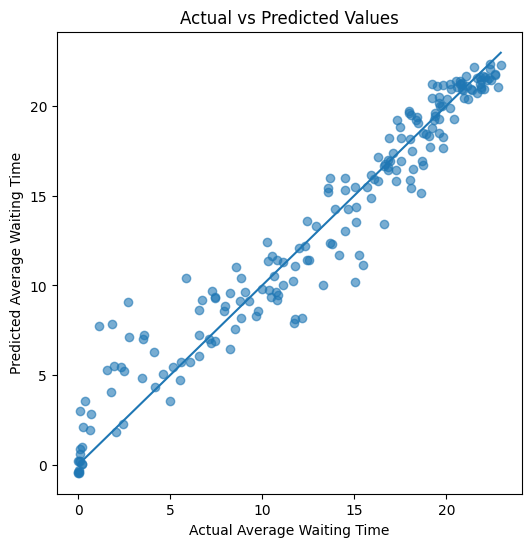

In [46]:
from sklearn.svm import SVR

best_model = SVR()
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.xlabel("Actual Average Waiting Time")
plt.ylabel("Predicted Average Waiting Time")
plt.title("Actual vs Predicted Values")

# Reference diagonal line
plt.plot(
    [y_test.min(), y_test.max()],
    [y_test.min(), y_test.max()]
)

plt.savefig("actual_vs_predicted.png", bbox_inches="tight")
plt.show()

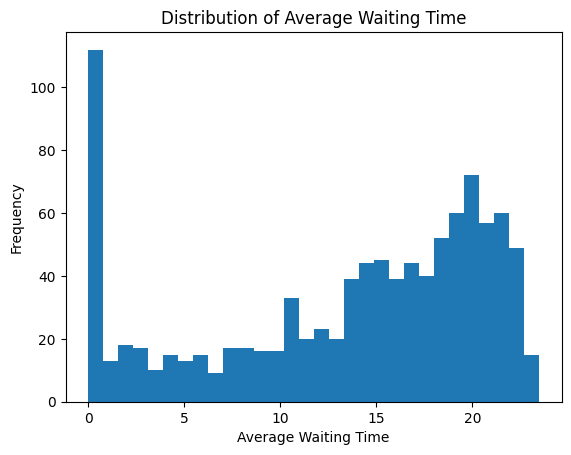

In [47]:
import matplotlib.pyplot as plt

plt.figure()
plt.hist(df["avg_wait_time"], bins=30)
plt.xlabel("Average Waiting Time")
plt.ylabel("Frequency")
plt.title("Distribution of Average Waiting Time")
plt.savefig("waiting_time_distribution.png", bbox_inches="tight")
plt.show()

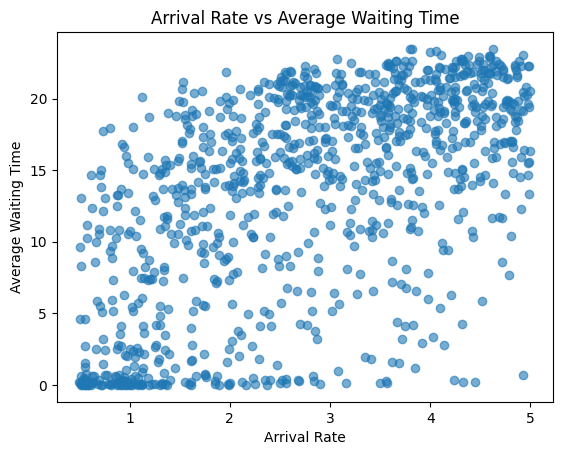

In [48]:
plt.figure()
plt.scatter(df["arrival_rate"], df["avg_wait_time"], alpha=0.6)
plt.xlabel("Arrival Rate")
plt.ylabel("Average Waiting Time")
plt.title("Arrival Rate vs Average Waiting Time")
plt.savefig("arrival_rate_vs_waiting_time.png", bbox_inches="tight")
plt.show()